# NOTE: This Colaboratory notebook is a copy from Lily's MagNet Github:
https://colab.research.google.com/github/liyo6397/MagNet/blob/master/benchmark.ipynb

## <<< Clone Lily's MagNet GitHub Repo for Dependencies

In [ ]:
!git clone https://github.com/liyo6397/MagNet.git

Cloning into 'MagNet'...
remote: Enumerating objects: 447, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 447 (delta 13), reused 64 (delta 11), pack-reused 375
Receiving objects: 100% (447/447), 797.81 MiB | 23.24 MiB/s, done.
Resolving deltas: 100% (175/175), done.
Checking out files: 100% (81/81), done.


In [ ]:
import sys
sys.path.insert(0,'/content/MagNet')

## >>> DONE Cloning MagNet Repo

# Benchmark neural network models

In [ ]:
# Benchmark neural network models

In [ ]:
import os
import datetime as dt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from model_definitions import define_model_cnn_1_min, define_model_lstm_hourly
from predict import load_models, predict_batch
from train import train_nn_models
import time
from typing import Callable, Tuple
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# download and save data
!wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
!unzip public.zip
!wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip
!unzip private.zip
!mkdir data
!mv public data
!mv private data

--2022-07-21 19:14:09--  https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
Resolving ngdc.noaa.gov (ngdc.noaa.gov)... 140.172.190.1
Connecting to ngdc.noaa.gov (ngdc.noaa.gov)|140.172.190.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 287399979 (274M) [application/zip]
Saving to: ‘public.zip’

public.zip          100%[===================>] 274.09M  6.49MB/s    in 44s     

2022-07-21 19:14:53 (6.29 MB/s) - ‘public.zip’ saved [287399979/287399979]

Archive:  public.zip
   creating: public/
  inflating: public/sunspots.csv     
  inflating: public/satellite_positions.csv  
  inflating: public/dst_labels.csv   
  inflating: public/solar_wind.csv   
--2022-07-21 19:15:04--  https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip
Resolving ngdc.noaa.gov (ngdc.noaa.gov)... 140.172.190.1
Connecting to ngdc.noaa.gov (ngdc.noaa.gov)|140.172.190.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112217628 (107M) [application/zip]

In [ ]:
# load data
data_folder = "data"
solar_train = pd.read_csv(os.path.join(data_folder, "public", "solar_wind.csv"))
dst_train = pd.read_csv(os.path.join(data_folder, "public", "dst_labels.csv"))
sunspots_train = pd.read_csv(os.path.join(data_folder, "public", "sunspots.csv"))
solar_test = pd.read_csv(os.path.join(data_folder, "private", "solar_wind.csv"))
dst_test = pd.read_csv(os.path.join(data_folder, "private", "dst_labels.csv"))
sunspots_test = pd.read_csv(os.path.join(data_folder, "private", "sunspots.csv"))

In [ ]:
# train and save model: CNN
output_folder = os.path.join("MagNet","trained_models", "cnn_1_min", "benchmark")
# os.makedirs(output_folder, exist_ok=True)
# # comment out training if model is already saved on disk
# train_nn_models(solar_train, sunspots_train, dst_train, define_model_cnn, 1, output_folder)

In [ ]:
# train and save model: LSTM
#output_folder = os.path.join("trained_models", "lstm", "benchmark")
# os.makedirs(output_folder, exist_ok=True)
# # comment out training if model is already saved on disk
# train_nn_models(solar_train, sunspots_train, dst_train, define_model_lstm, 1, output_folder)

In [ ]:
# measure performance on train and test
t = time.time()
model_t_arr, model_t_plus_1_arr, norm_df = load_models(output_folder, 1)
dst_test["timedelta"] = pd.to_timedelta(dst_test["timedelta"])
# exclude times in the first week of dst_test
dst_test = dst_test.loc[dst_test["timedelta"] >= dt.timedelta(days=7)]
frequency = "minute" #minute for cnn; hour for lstm
predictions = predict_batch(
    solar_test, sunspots_test, dst_test, model_t_arr, model_t_plus_1_arr, norm_df, frequency
)
dst_test = pd.merge(dst_test, predictions, "left", ["timedelta", "period"])
dst_test["dst_t_plus_1"] = dst_test.groupby("period")["dst"].shift(-1)
loss_t = np.sqrt(
    mean_squared_error(dst_test["dst"].values, dst_test["prediction_t"].values)
)
valid_ind = dst_test["dst_t_plus_1"].notnull()
loss_t_plus_1 = np.sqrt(
    mean_squared_error(
        dst_test.loc[valid_ind, "dst_t_plus_1"].values,
        dst_test.loc[valid_ind, "prediction_t_plus_1"].values,
    )
)
prediction_time = time.time() - t

print(f"RMSE for time t: {loss_t:0.2f}")
print(f"RMSE for time t+1: {loss_t_plus_1:0.2f}")
print(f"Prediction time: {prediction_time:0.1f}s")


RMSE for time t: 12.34
RMSE for time t+1: 12.76
Prediction time: 103.9s


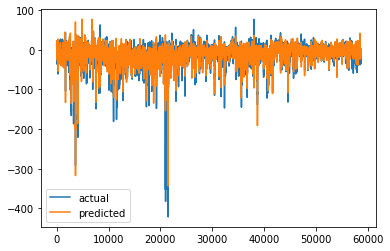

In [ ]:
plt.figure()
plt.plot(dst_test.loc[valid_ind, "dst"].values)
plt.plot(dst_test.loc[valid_ind, "prediction_t"].values)
plt.legend(["actual", "predicted"])